In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import minimum_filter, maximum_filter

In [ ]:
# Load the image in grayscale
image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)

if image is None:
    print("Error: Image not found or unable to open.")

### **Activity 1: Contrast Stretching**

**Question:**
Contrast stretching improves the visibility of features in low-contrast images by expanding the gray-level range of the image. It is often done using a piecewise linear function that maps input pixel values to a wider range of output values, enhancing contrast especially in specific intensity regions.

A simple piecewise linear contrast stretching can be defined by three points $(r_1, s_1)$ and $(r_2, s_2)$ where:

-   For $0 \leq r \leq r_1$, output $s = \frac{s_1}{r_1} \times r$
-   For $r_1 < r \leq r_2$, output $s = \frac{s_2 - s_1}{r_2 - r_1} \times (r - r_1) + s_1$
-   For $r_2 < r \leq L-1$, output $s = \frac{L-1 - s_2}{L-1 - r_2} \times (r - r_2) + s_2$

Here, $L$ is the number of gray levels (usually 256).

### **Explanation:**

-   This function stretches the contrast by mapping a narrow range of input intensities $[r_1, r_2]$ to a wider range $[s_1, s_2]$.
-   Pixels below $r_1$ and above $r_2$ are stretched linearly to cover the remaining intensity ranges.
-   This improves details in specific intensity ranges while preserving overall image information.


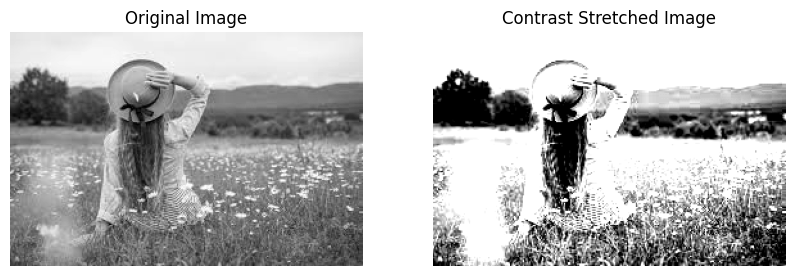

In [ ]:
def contrast_stretching(image, r1, s1, r2, s2):
    # Create output image
    stretched = np.zeros_like(image, dtype=np.uint8)

    # Apply piecewise linear function pixel-wise
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            r = image[i, j]
            if r <= r1:
                s = (s1 / r1) * r
            elif r1 < r <= r2:
                s = ((s2 - s1) / (r2 - r1)) * (r - r1) + s1
            else:
                s = ((255 - s2) / (255 - r2)) * (r - r2) + s2
            stretched[i, j] = np.clip(s, 0, 255)

    return stretched

# Define control points
r1, s1 = 70, 0
r2, s2 = 140, 255

stretched_image = contrast_stretching(image, r1, s1, r2, s2)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Contrast Stretched Image')
plt.axis('off')
plt.imshow(stretched_image, cmap='gray')

plt.show()

### **Activity 2: Gray Level Slicing**

**Question:**
Gray level slicing highlights specific ranges of intensities in an image, enhancing features of interest such as tissues or structures. This is done by emphasizing a certain intensity range and suppressing others.

There are two main types:

-   **With background preservation:** Intensities within the selected range are enhanced (e.g., set to max), and others remain unchanged.
-   **Without background preservation:** Intensities within the selected range are enhanced, and all other pixels are suppressed (e.g., set to zero).

### **Explanation:**

-   You specify a range $[r_1, r_2]$ of intensities to highlight.
-   Pixels inside this range are mapped to a high intensity (like 255).
-   Pixels outside the range can either be left as-is (background preserved) or set to zero (background suppressed).
-   Useful in medical imaging or industrial inspection to highlight features with particular gray levels.


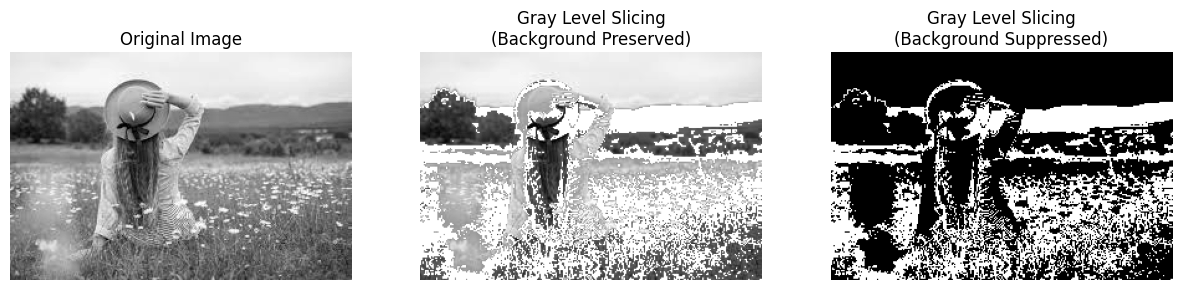

In [ ]:
def gray_level_slicing(image, r1, r2, preserve_background=True):
    sliced = np.copy(image)

    highlight_value = 255

    if preserve_background:
        sliced[(image >= r1) & (image <= r2)] = highlight_value
    else:
        sliced[(image >= r1) & (image <= r2)] = highlight_value
        sliced[(image < r1) | (image > r2)] = 0

    return sliced

# Define the gray level range to highlight
r1, r2 = 100, 150

sliced_preserved = gray_level_slicing(image, r1, r2, preserve_background=True)
sliced_suppressed = gray_level_slicing(image, r1, r2, preserve_background=False)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(1,3,2)
plt.title('Gray Level Slicing\n(Background Preserved)')
plt.axis('off')
plt.imshow(sliced_preserved, cmap='gray')

plt.subplot(1,3,3)
plt.title('Gray Level Slicing\n(Background Suppressed)')
plt.axis('off')
plt.imshow(sliced_suppressed, cmap='gray')

plt.show()


### **Activity 3: Bit-Plane Slicing**

**Question:**
Bit-plane slicing decomposes a grayscale image into its individual binary bit planes to analyze the contribution of each bit to the overall image quality. Each bit plane represents the image formed by that particular bit across all pixel intensities.

-   The **Most Significant Bit (MSB)** plane contains the highest order bit and contributes most to the image appearance.
-   The **Least Significant Bit (LSB)** plane contains the lowest order bit and contributes the least.

### **Explanation:**

-   Each pixel in an 8-bit image can be represented in binary as 8 bits: $b_7 b_6 b_5 b_4 b_3 b_2 b_1 b_0$ (MSB is $b_7$, LSB is $b_0$).
-   Bit-plane slicing extracts each bit plane as a binary image where pixels are 1 if that bit is set, else 0.
-   Viewing these planes reveals how much information each bit contributes.


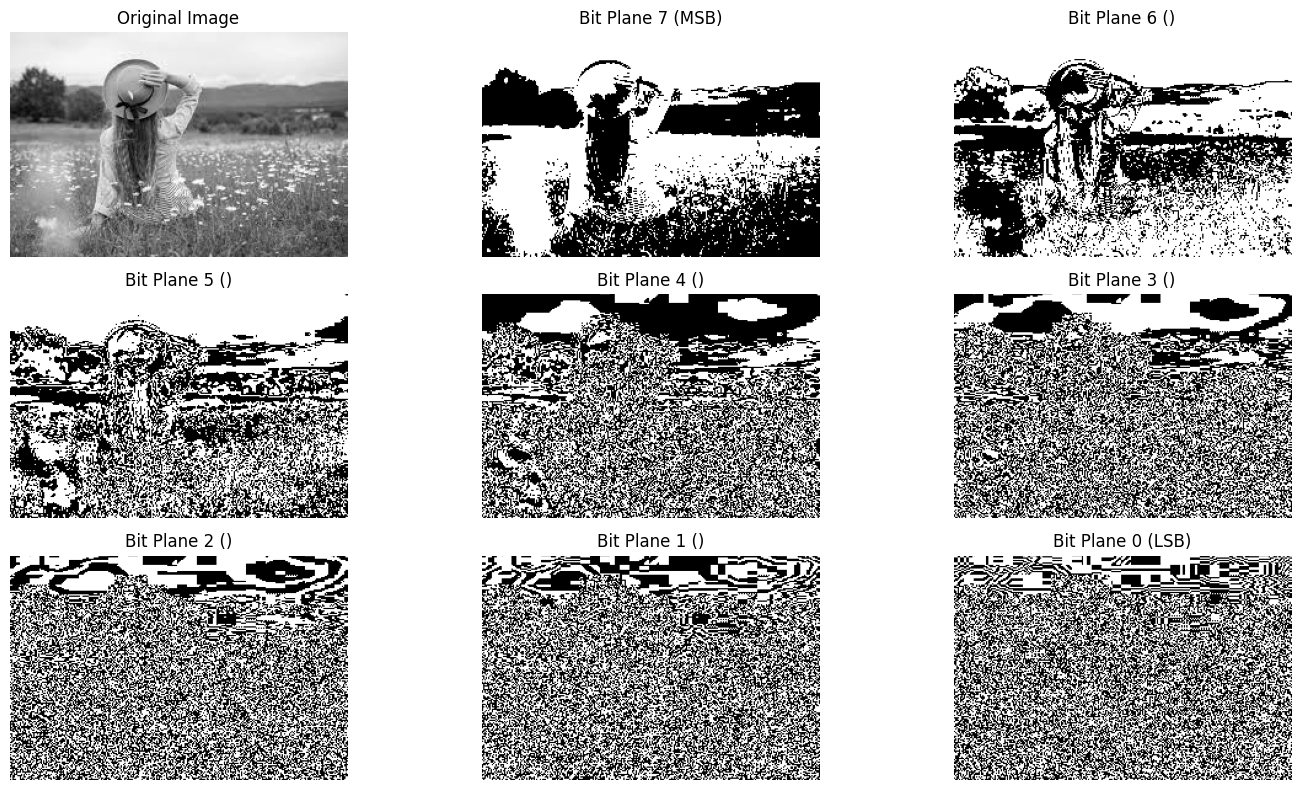

In [ ]:
bit_planes = []

for bit in range(7, -1, -1):
    bit_plane = (image >> bit) & 1
    bit_planes.append(bit_plane * 255)

plt.figure(figsize=(15, 8))

plt.subplot(3, 3, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(image, cmap='gray')

for i, bp in enumerate(bit_planes, start=2):
    plt.subplot(3, 3, i)
    plt.title(f'Bit Plane {7 - (i - 2)} ({"MSB" if i == 2 else "LSB" if i == 9 else ""})')
    plt.axis('off')
    plt.imshow(bp, cmap='gray')

plt.tight_layout()
plt.show()


## **Activity 4: Smoothing / Sharpening Filters**

### **Part A – Smoothing Filters**

Reduce noise and enhance the background to reveal hidden or less-visible objects/features using:

-   Moving Average Filter (3×3)
-   Order-Statistic Filters: Median, Min, and Max Filters

### **Part B – Sharpening Filter**

Enhance important details like edges, textures, and fine details using a Laplacian filter.

### **Explanation:**

-   **Moving Average Filter:** Smooths the image by averaging pixel values in a 3×3 neighborhood, reducing noise but can blur edges.
-   **Median Filter:** A nonlinear filter replacing each pixel with the median of its neighborhood; effective for salt-and-pepper noise.
-   **Min Filter:** Takes the minimum value in the neighborhood, useful for removing bright noise and shrinking bright objects.
-   **Max Filter:** Takes the maximum value in the neighborhood, useful for removing dark noise and expanding bright objects.
-   **Laplacian Filter:** A second derivative filter that highlights regions of rapid intensity change, sharpening edges and textures.


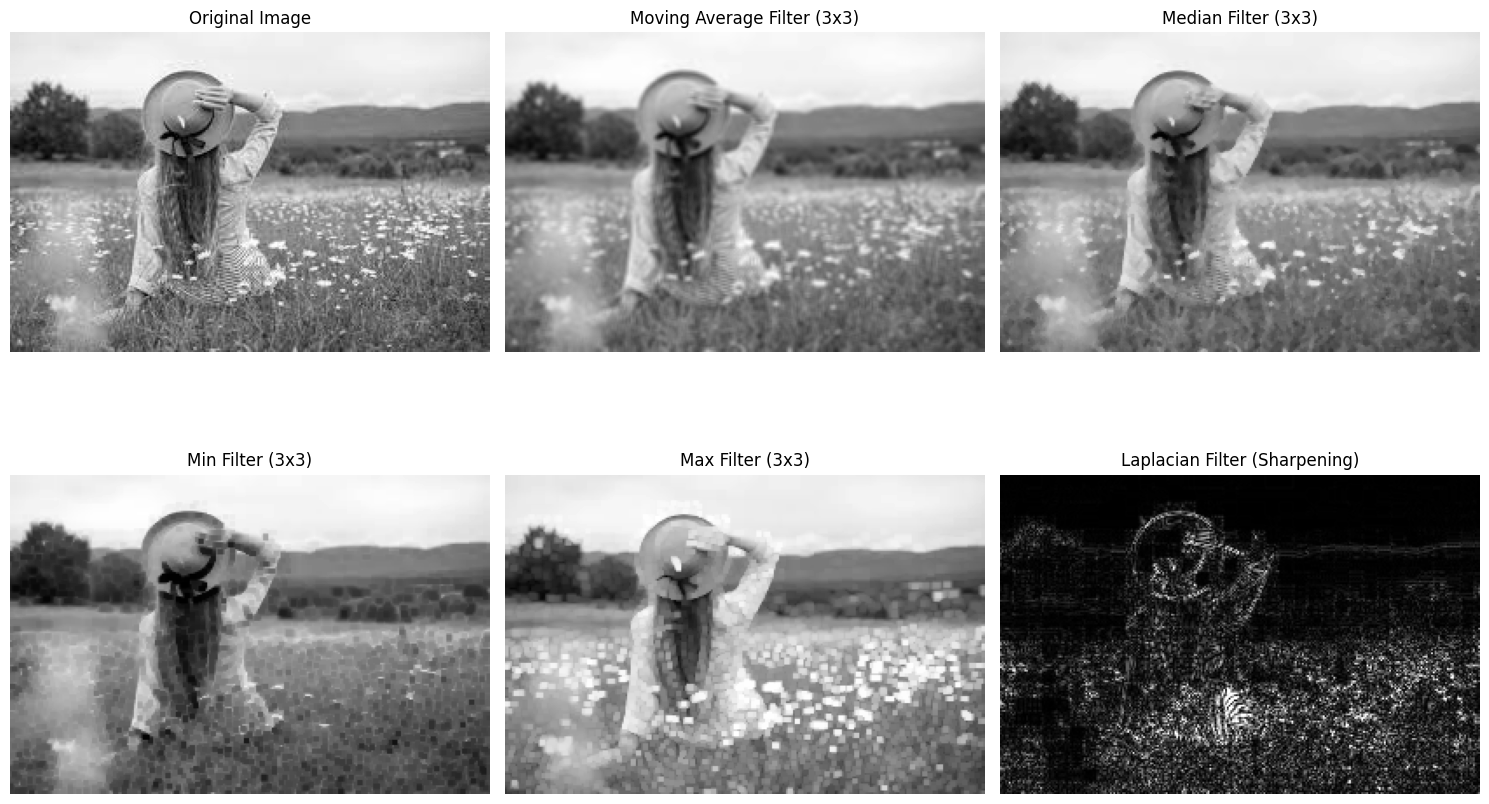

In [ ]:
# Part A: Smoothing Filters
moving_average = cv2.blur(image, (3, 3))
median_filtered = cv2.medianBlur(image, 3)
min_filtered = minimum_filter(image, size=3)
max_filtered = maximum_filter(image, size=3)

# Part B: Sharpening Filter - Laplacian Filter
laplacian = cv2.Laplacian(image, cv2.CV_64F)
laplacian_abs = cv2.convertScaleAbs(laplacian)

# Plotting results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.title('Original Image')
plt.axis('off')
plt.imshow(image, cmap='gray')

plt.subplot(2, 3, 2)
plt.title('Moving Average Filter (3x3)')
plt.axis('off')
plt.imshow(moving_average, cmap='gray')

plt.subplot(2, 3, 3)
plt.title('Median Filter (3x3)')
plt.axis('off')
plt.imshow(median_filtered, cmap='gray')

plt.subplot(2, 3, 4)
plt.title('Min Filter (3x3)')
plt.axis('off')
plt.imshow(min_filtered, cmap='gray')

plt.subplot(2, 3, 5)
plt.title('Max Filter (3x3)')
plt.axis('off')
plt.imshow(max_filtered, cmap='gray')

plt.subplot(2, 3, 6)
plt.title('Laplacian Filter (Sharpening)')
plt.axis('off')
plt.imshow(laplacian_abs, cmap='gray')

plt.tight_layout()
plt.show()
